---
title: "Fake News Classification using TensorFlow"
author: "Jun Ryu"
date: "2023-02-28"
categories: [ML]
---

# Acquiring Training Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
train_df = pd.read_csv(train_url)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
...,...,...,...,...
22444,10709,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,1
22445,8731,Can Pence's vow not to sling mud survive a Tru...,"() - In 1990, during a close and bitter congre...",0
22446,4733,Watch Trump Campaign Try To Spin Their Way Ou...,A new ad by the Hillary Clinton SuperPac Prior...,1
22447,3993,"Trump celebrates first 100 days as president, ...","HARRISBURG, Pa.U.S. President Donald Trump hit...",0


# Making a Dataset

In [2]:
def make_dataset(df):
  df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  Dataset = tf.data.Dataset.from_tensor_slices(({
      "title" : df[["title"]],
      "text" : df[["text"]]
  }, {
      "fake" : df["fake"]
  }))
  Dataset = Dataset.batch(100)
  return Dataset

data = make_dataset(train_df)
data = data.shuffle(buffer_size = len(data))

train_size = int(0.8*len(data))
val_size   = int(0.2*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [3]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

text_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

In [4]:
title_input = keras.Input(
    shape=(1,),
    name = "title", # same name as the dictionary key in the dataset
    dtype = "string"
)

text_input = keras.Input(
    shape=(1,),
    name = "text", # same name as the dictionary key in the dataset
    dtype = "string"
)

# First Model (Title Only)

In [5]:
title_features = title_vectorize_layer(title_input) # apply this "function TextVectorization layer" to title_input
title_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(2, activation='relu', name="fake")(title_features)

In [6]:
model1 = keras.Model(
    inputs = [title_input],
    outputs = title_features
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout (Dropout)           (None, 500, 3)            0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0     

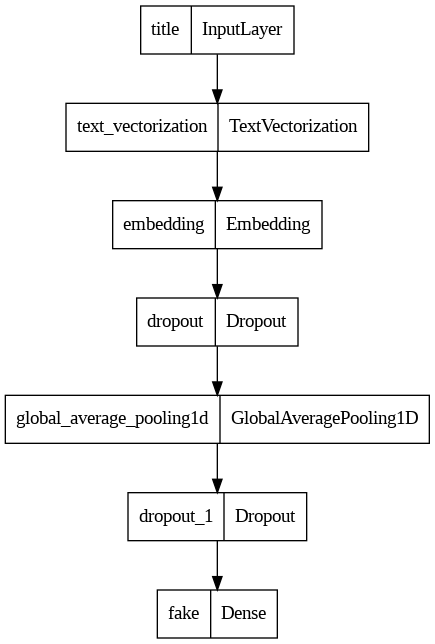

In [7]:
from tensorflow.keras import utils
utils.plot_model(model1)

In [8]:
model1.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [9]:
history = model1.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 18s 85ms/step - loss: 0.6919 - accuracy: 0.5217 - val_loss: 0.6908 - val_accuracy: 0.5253
Epoch 2/20
180/180 [==============================] - 2s 11ms/step - loss: 0.6899 - accuracy: 0.5273 - val_loss: 0.6889 - val_accuracy: 0.5264
Epoch 3/20
180/180 [==============================] - 1s 7ms/step - loss: 0.6882 - accuracy: 0.5217 - val_loss: 0.6866 - val_accuracy: 0.5222
Epoch 4/20
180/180 [==============================] - 1s 5ms/step - loss: 0.6845 - accuracy: 0.5250 - val_loss: 0.6822 - val_accuracy: 0.5278
Epoch 5/20
180/180 [==============================] - 1s 5ms/step - loss: 0.6801 - accuracy: 0.5323 - val_loss: 0.6778 - val_accuracy: 0.5219
Epoch 6/20
180/180 [==============================] - 1s 6ms/step - loss: 0.6727 - accuracy: 0.6283 - val_loss: 0.6675 - val_accuracy: 0.5720
Epoch 7/20
180/180 [==============================] - 1s 7ms/step - loss: 0.6589 - accuracy: 0.7197 - val_loss: 0.6514 - val_accuracy: 0.6769
Epoch 8/20
180

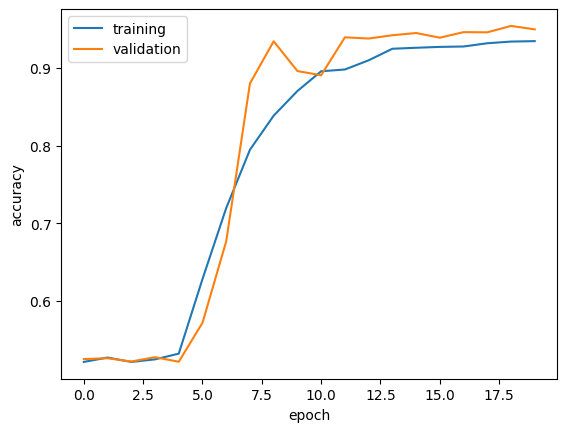

In [10]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Second Model (Text Only)

In [11]:
text_features = text_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(2, activation='relu', name="fake")(text_features)

In [12]:
model2 = keras.Model(
    inputs = [text_input],
    outputs = text_features
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 3)            6000      
                                                                 
 dropout_2 (Dropout)         (None, 500, 3)            0         
                                                                 
 global_average_pooling1d_1   (None, 3)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0   

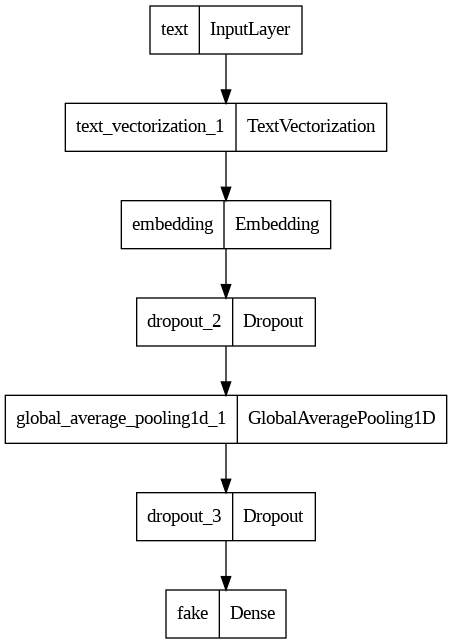

In [13]:
from tensorflow.keras import utils
utils.plot_model(model2)

In [14]:
model2.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [15]:
history = model2.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 17s 90ms/step - loss: 0.6862 - accuracy: 0.5512 - val_loss: 0.6709 - val_accuracy: 0.8756
Epoch 2/20
180/180 [==============================] - 5s 26ms/step - loss: 0.6508 - accuracy: 0.8443 - val_loss: 0.6268 - val_accuracy: 0.8728
Epoch 3/20
180/180 [==============================] - 3s 15ms/step - loss: 0.6049 - accuracy: 0.8679 - val_loss: 0.5757 - val_accuracy: 0.9387
Epoch 4/20
180/180 [==============================] - 2s 13ms/step - loss: 0.5538 - accuracy: 0.8967 - val_loss: 0.5255 - val_accuracy: 0.9327
Epoch 5/20
180/180 [==============================] - 3s 14ms/step - loss: 0.5053 - accuracy: 0.9087 - val_loss: 0.4718 - val_accuracy: 0.9424
Epoch 6/20
180/180 [==============================] - 2s 12ms/step - loss: 0.4598 - accuracy: 0.9204 - val_loss: 0.4298 - val_accuracy: 0.9433
Epoch 7/20
180/180 [==============================] - 2s 12ms/step - loss: 0.4196 - accuracy: 0.9289 - val_loss: 0.3907 - val_accuracy: 0.9447
Epoch 8/2

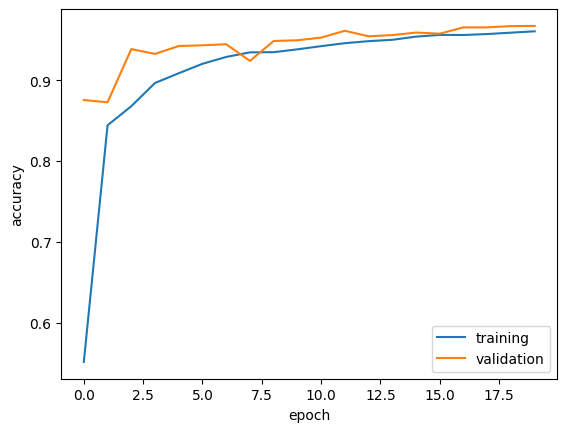

In [16]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Third Model (Title AND Text)

In [17]:
title_features = title_vectorize_layer(title_input)
text_features = text_vectorize_layer(text_input)
shared_embedding = layers.Embedding(size_vocabulary, 10)
title_features = shared_embedding(title_features)
text_features = shared_embedding(text_features)
title_features = layers.Dense(32, activation='relu')(title_features)
text_features = layers.Dense(32, activation='relu')(text_features)

main = layers.concatenate([title_features, text_features], axis = 1)
main = layers.Dropout(0.2)(main)
main = layers.GlobalAveragePooling1D()(main)
main = layers.Dropout(0.2)(main)
main = layers.Dense(2, activation='relu', name = 'fake')(main)


In [18]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = main
)

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['title[0][0]']                  
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 500)         0           ['text[0][0]']             

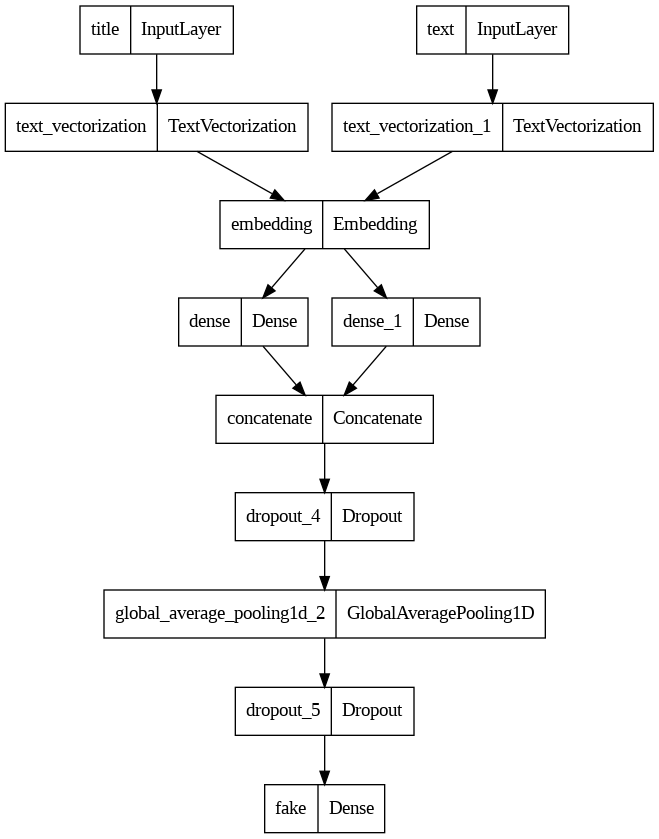

In [19]:
keras.utils.plot_model(model3)

In [20]:
model3.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [21]:
history = model3.fit(train,
                    validation_data=val,
                    epochs = 20,
                    verbose = True)

Epoch 1/20
180/180 [==============================] - 18s 88ms/step - loss: 0.6720 - accuracy: 0.6223 - val_loss: 0.6163 - val_accuracy: 0.9056
Epoch 2/20
180/180 [==============================] - 4s 23ms/step - loss: 0.4981 - accuracy: 0.8568 - val_loss: 0.3657 - val_accuracy: 0.9282
Epoch 3/20
180/180 [==============================] - 3s 15ms/step - loss: 0.3155 - accuracy: 0.9128 - val_loss: 0.2441 - val_accuracy: 0.9507
Epoch 4/20
180/180 [==============================] - 3s 17ms/step - loss: 0.2429 - accuracy: 0.9341 - val_loss: 0.1935 - val_accuracy: 0.9564
Epoch 5/20
180/180 [==============================] - 3s 16ms/step - loss: 0.2019 - accuracy: 0.9461 - val_loss: 0.1591 - val_accuracy: 0.9682
Epoch 6/20
180/180 [==============================] - 3s 16ms/step - loss: 0.1772 - accuracy: 0.9538 - val_loss: 0.1460 - val_accuracy: 0.9691
Epoch 7/20
180/180 [==============================] - 3s 16ms/step - loss: 0.1558 - accuracy: 0.9592 - val_loss: 0.1270 - val_accuracy: 0.972

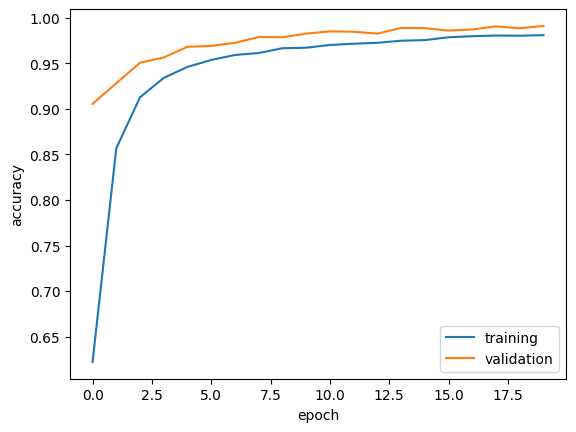

In [22]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Best Model Evaluation

In [23]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test = make_dataset(test_df)

model3.evaluate(test, verbose=1)

225/225 [==============================] - 2s 10ms/step - loss: 0.0627 - accuracy: 0.9848


[0.06266233325004578, 0.9847654700279236]

# Embedding Visualization

In [24]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = title_vectorize_layer.get_vocabulary() # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [25]:
import plotly.express as px
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = [2]*len(embedding_df),
                # size_max = 2,
                 hover_name = "word")

fig.show()